In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

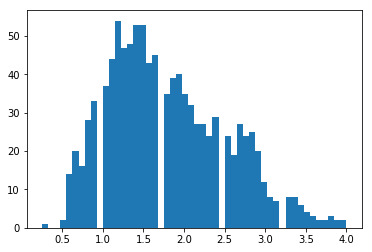

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


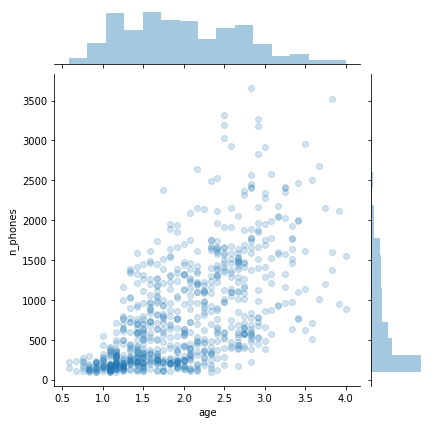

In [10]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [41]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

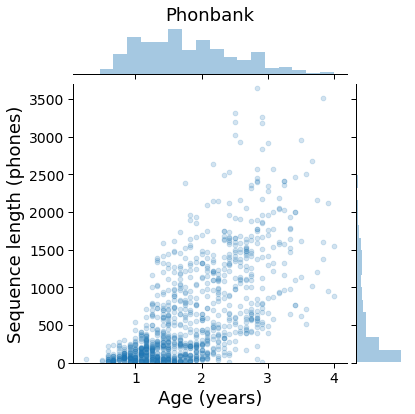

In [45]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age", "n_phones", data=phone_df, alpha=0.2, annot_kws={"size": 16})

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (phones)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("Phonbank")
p.ax_joint.set_ylim([0,3700])
save_fig(FIGURE_DIR/ 'distributions' / 'phonbank_distribution')
plt.show()

In [ ]:
p.ax_joint

In [11]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [12]:
from childes_mi.information_theory import mutual_information as mi

In [13]:
distances = np.arange(1,101)

#### Run MI by age cohort

In [14]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [15]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [16]:
def concat(arr):
    """ingore concatenation of zero length list"""
    if len(arr) ==0:
        return []
    else:
        return np.concatenate(arr)

In [22]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [23]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        'shuffling'
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    ### make list of phones
    cohort_phones_list = [
        [
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list:', [' '.join(i) for i in cohort_phones_list][0][:100])
    
    cohort_phones_list_no_repeats = [
        remove_repeats([
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ])
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (no repeats):', [' '.join(i) for i in cohort_phones_list_no_repeats][0][:100])

    ### make list of phones shuffled within words
    cohort_phones_list_shuffled_within_words = [
            list(concat([np.random.permutation(list(i)) for i in flatten(row.phones) if i is not None]))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled within word):', [' '.join(i) for i in cohort_phones_list_shuffled_within_words][0][:100])

    ### make list of phones shuffled between words
    cohort_phones_list_shuffled_between_words = [
            list(''.join(list(np.random.permutation([i for i in flatten(row.phones) if i is not None]))))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled between word):', [' '.join(i) for i in cohort_phones_list_shuffled_between_words][0][:100])

    cohort_phones_list_shuffled_within_sentence = [list(np.concatenate([np.random.permutation(list(''.join(list(flatten([i for i in sent if i is not None]))))) for sent in  trans]))
     for trans in cohort_subset.phones.values]
    print('phones list (shuffled within sentences):', [' '.join(i) for i in cohort_phones_list_shuffled_within_sentence][0][:100])

    # get number of unique elements
    n_phones = len(np.concatenate(cohort_phones_list))
    n_unique_phones = 0 #len(np.unique(np.concatenate(cohort_phones)))
    
    # make each phone symbol specific to the transcript
    for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
        cohort_phones_list[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_within_sentence[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_within_sentence[transcript_i]]
        cohort_phones_list_no_repeats[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_no_repeats[transcript_i]]

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'full'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_between_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_between_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_sentence, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_sentence'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_no_repeats, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'no_repeats'
    ]

phones list: ˈ n a ɪ ʌ ˈ j ɪ ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ 
phones list (no repeats): ˈ n a ɪ ʌ ˈ j ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ m 
phones list (shuffled within word): a ˈ ɪ n ˈ j ɪ ʌ b ˈ ʌ m ɪ ʌ ə b ˈ m d ˈ ɛ ɑ ˈ b ˈ ɛ m ˈ i ɪ ˈ b ˈ ʌ ɛ a ɪ t ˈ ˈ ɡ ɪ ˈ ɪ a ɡ d ˈ ʌ m 
phones list (shuffled between word): a ɪ ɛ ˈ ɡ ɛ ˈ ɛ ˈ h ɛ ˈ e ɪ ˈ a ɪ n ̩ ˈ d ɪ s ˈ ɡ e ɪ ˈ t a ɪ ɛ ˈ d ɛ ˈ h ɛ ˈ l ɛ ʔ a ɪ ˈ d ɑ u e ɪ 
phones list (shuffled within sentences): ɪ n a ˈ ʌ j ɪ ˈ m ʌ ɪ ˈ b ʌ ə m ˈ b ˈ d ɛ ˈ ɑ b ɛ ˈ i m ˈ ɪ ˈ b ʌ ˈ ɪ t a ɛ ˈ ˈ ɡ ɡ ɪ ˈ ɪ a d ˈ ʌ m 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    6.8s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    7.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.1s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.4s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    8.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.0s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    8.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    6.8s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    7.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


phones list: ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (no repeats): ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (shuffled within word): a ʊ ˈ ˈ u i ˈ ɑ ˈ ˈ ɔ ð e ˈ i ɪ ð ˈ ʊ a ɪ z ˈ j ˈ æ ˈ ɪ ɔ ˈ ʌ ɔ ʔ ː ə ˈ ː ʔ ˈ ɔ ə o ˈ i ː ˈ ː ˈ i ː 
phones list (shuffled between word): ˈ b u ː ˈ ɪ ˈ w ɛ ̃ ˈ d æ ˈ p æ ˈ d ɪ ˈ b u ˈ b ɪ d ʒ ə ˈ b ɪ ˈ w ʌ ʔ o ˈ b ʌ ʔ ˈ u ː n ə ˈ m i ̃ ˈ 
phones list (shuffled within sentences): ʊ a ˈ i u ˈ ˈ ɔ ɑ ˈ ˈ ˈ e ð i a ɪ ˈ ʊ ð æ j z ɪ ˈ ˈ ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ə ʔ ˈ ː ɔ ə ʔ o ˈ i ˈ ː ˈ i ː i 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   20.1s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   29.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   25.9s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   26.0s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   20.6s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   29.6s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   25.3s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   25.3s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   20.4s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   29.5s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.1s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   24.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   20.3s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   29.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.9s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   24.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.4s finished


phones list: h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (no repeats): h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (shuffled within word): ɪ h ˈ m i u b ˈ ə t h s ɪ ˈ ɪ * ʊ ˈ ʌ h ə ˈ u b * ɪ e h ː ˈ ˈ t ʌ m i ˈ ɑ m ɪ ˈ i ɾ s ə w æ ˈ ʔ s e 
phones list (shuffled between word): ˈ ʌ t ˈ ɪ t s ˈ a ɪ w ə ˈ s æ ˈ d ʒ i ˈ d ɪ o ˈ n o ˈ ɑ m o ˈ w ʌ t s ˈ t w i b ɑ ˈ p ɑ p ˈ m ɑ m i 
phones list (shuffled within sentences): m ˈ ɪ h i b ˈ u ʌ s ɪ * h ˈ ɪ ˈ t ə ʊ h u ə b ˈ h ː ˈ e * ɪ t ʌ ˈ ˈ i ɑ m m ɪ ɾ s i ˈ æ ə ˈ w s ʔ e 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.1s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   34.8s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   33.2s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   33.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.5s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.2s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   31.9s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   31.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   22.7s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   34.5s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   33.1s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   33.1s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.8s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   34.6s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   33.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   33.7s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.6s finished


phones list: ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (no repeats): ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (shuffled within word): ɛ z ˈ o k b ˈ ɑ * ˈ m ɑ i m ˈ w ɪ e ɪ m ː ɛ ˈ m ˈ m i ɑ ɛ ˈ m i m ɑ ˈ ɛ ˈ i ɑ m m ˈ ˈ ɛ i ɑ m m ˈ i 
phones list (shuffled between word): ˈ b i ˈ w a ɪ ˈ w e ɪ ˈ ɛ ː s ˈ t u ɪ ˈ t i ˈ o ˈ ɪ ˈ b u ˈ ɛ n ˈ w a ɪ ˈ w ʌ ɾ ə ˈ ʌ ɾ ə ˈ ɛ m o ˈ 
phones list (shuffled within sentences): z k o ˈ ˈ ɑ ɛ b * m ɪ e i w ˈ ɑ ˈ m ɪ m m i ɛ ˈ m ɑ ˈ ː ɛ m ɑ ˈ i ˈ m i ˈ ˈ m i ɑ ɑ m ˈ ˈ m ɛ m ɛ ʌ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   25.6s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   37.8s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   35.1s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   35.1s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    2.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   25.4s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.7s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   35.0s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   35.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   25.5s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.7s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   35.1s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   35.1s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.9s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   36.4s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.8s finished


phones list: ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (no repeats): ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (shuffled within word): ˈ i h æ h ˈ ə r s ˈ h i ˈ æ h s ə r æ v ˈ ə ʔ k ˈ p s i l p s ʊ ˈ o ˈ n a w f ɪ ˈ ʌ ˈ n ˈ ʌ n o ˈ n 
phones list (shuffled between word): ˈ k w æ ʃ ˈ w o ˈ w ɛ s ɪ s ˈ m ɑ m i ˈ w ʌ t s ˈ w ʌ t s ˈ ɪ ə s æ t ˈ t ʃ e ɪ ˈ w ʌ t s ˈ ɪ s ˈ s 
phones list (shuffled within sentences): ˈ ˈ h ə h s æ i r s ə h r ˈ i h ˈ æ ə ˈ s p ʔ k æ l i v ˈ s ʊ ˈ p ˈ o n w a ɪ f ˈ o n n ʌ ʌ ˈ ˈ n ˈ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.7s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.2s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   34.9s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   34.9s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.8s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.0s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   35.4s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   35.4s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   25.5s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   37.4s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   32.3s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   32.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   24.5s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   36.6s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   32.9s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   32.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished


phones list: ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (no repeats): ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (shuffled within word): ɛ ˈ s j p z l ˈ i ʊ l ˈ k a ˈ ɪ h ʒ i i d ˈ ʒ ˈ d ˈ ʌ w d i o ˈ z ɛ ˈ w ˈ l ə t z s ɛ ˈ ɪ ɡ n * s ˈ 
phones list (shuffled between word): ˈ b w i d ə ˈ n o s ˈ æ p o ð ə ˈ l ʊ k ˈ a ɪ ˈ d ʒ i ŋ ɡ ə ˈ ð æ s ˈ a ʊ ˈ f æ ː ə z ˈ w ɪ ɡ ə l ɪ 
phones list (shuffled within sentences): j ɛ ˈ s z i l p ˈ l k ˈ ʊ d d ˈ ˈ ɪ a ˈ i h ʒ ʒ i ˈ w ʌ ˈ o i d w l n z s ˈ z t ɡ ˈ ɛ ˈ ɛ ə ɪ æ d i 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   14.2s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   21.2s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   19.7s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   19.7s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    2.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   14.9s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   21.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   18.4s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   18.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   14.9s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   21.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   19.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   19.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   14.7s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   21.6s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   19.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   19.7s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished


In [24]:
mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_with_shuffling.pickle")

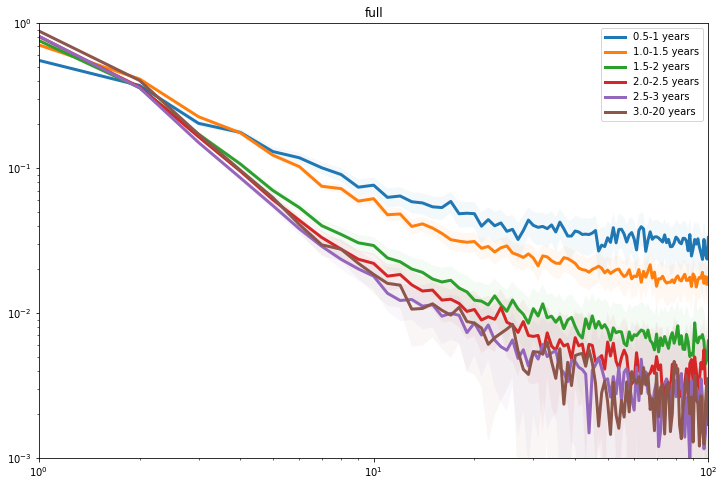

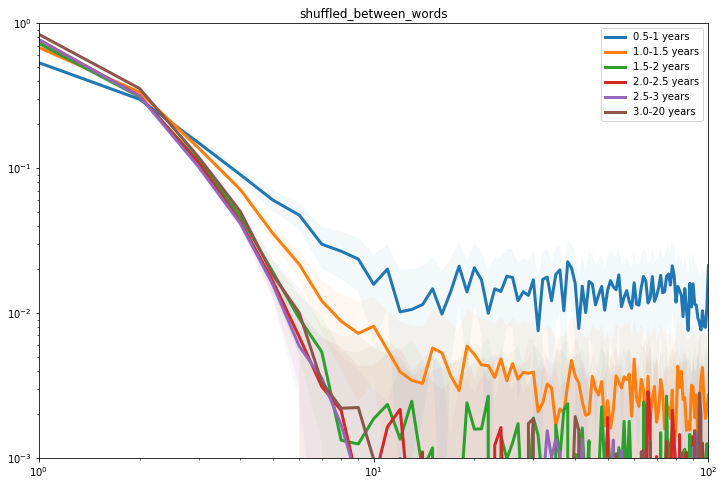

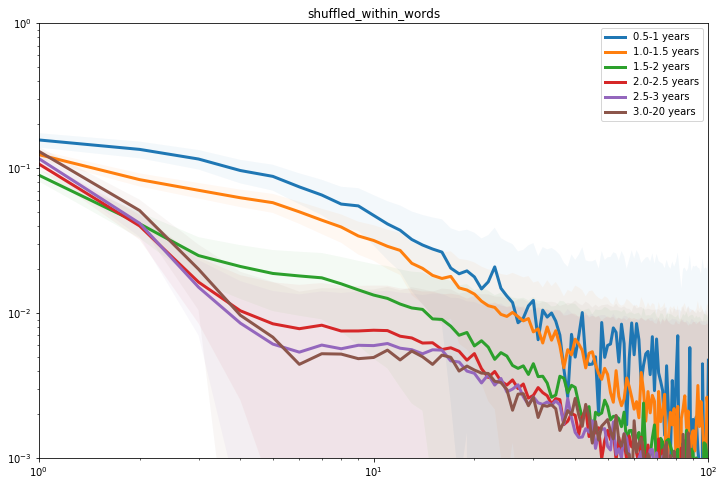

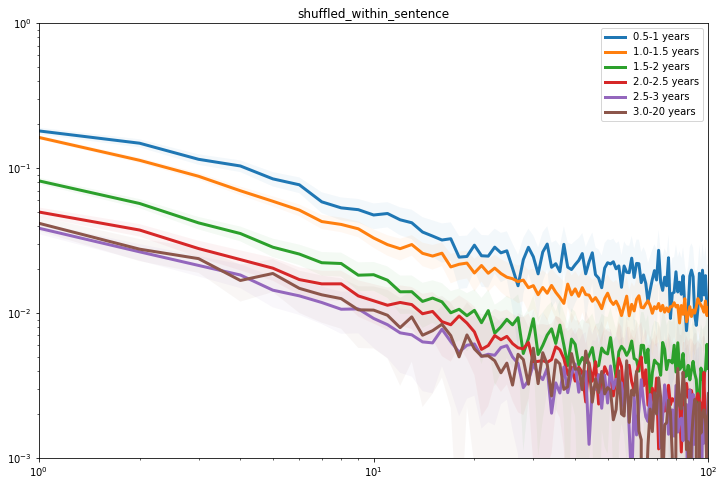

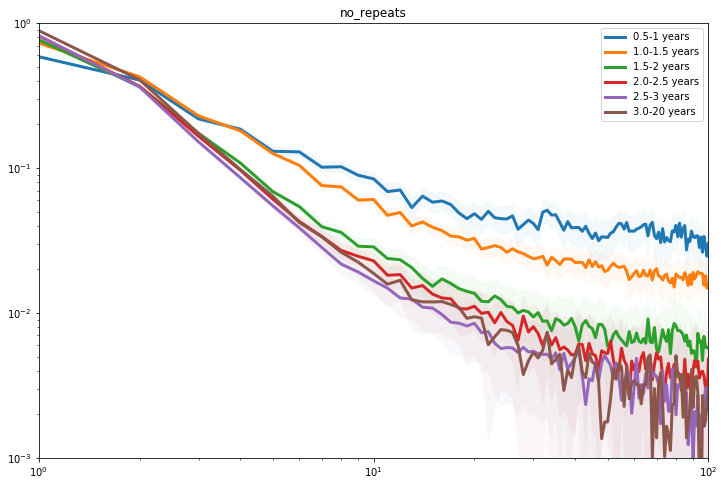

In [25]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_sentence', 'no_repeats']:
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title(shuff)
    for idx, row in mi_df.iterrows():
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.05)

    ax.legend()
    ax.set_ylim([1e-3,1])
    ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()

full


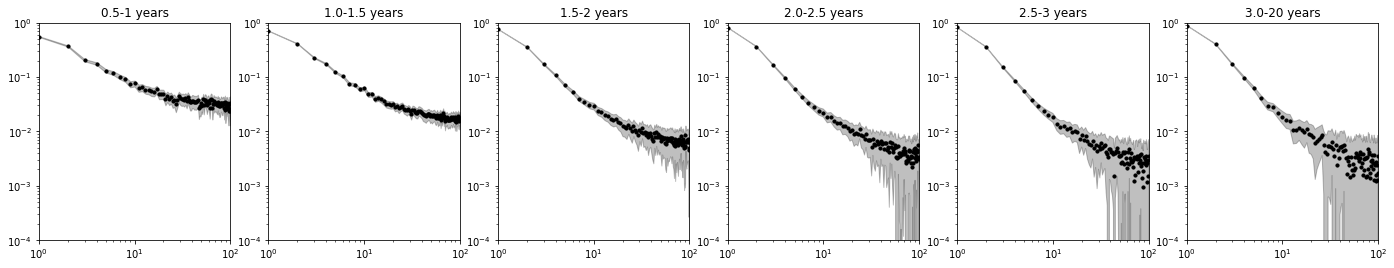

shuffled_between_words


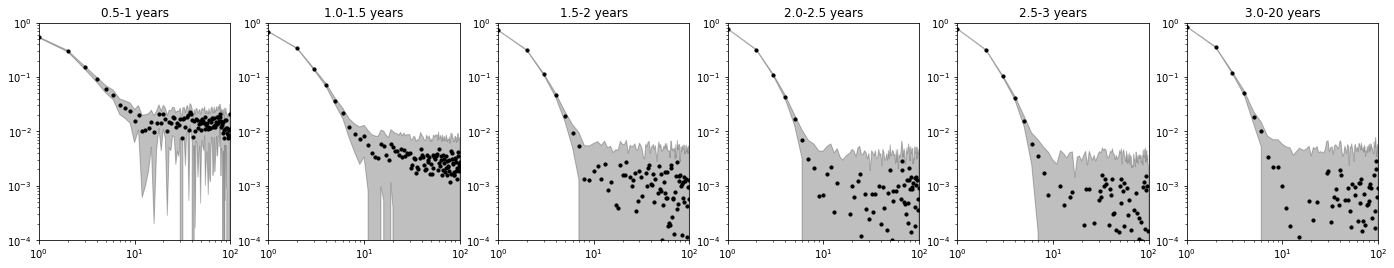

shuffled_within_words


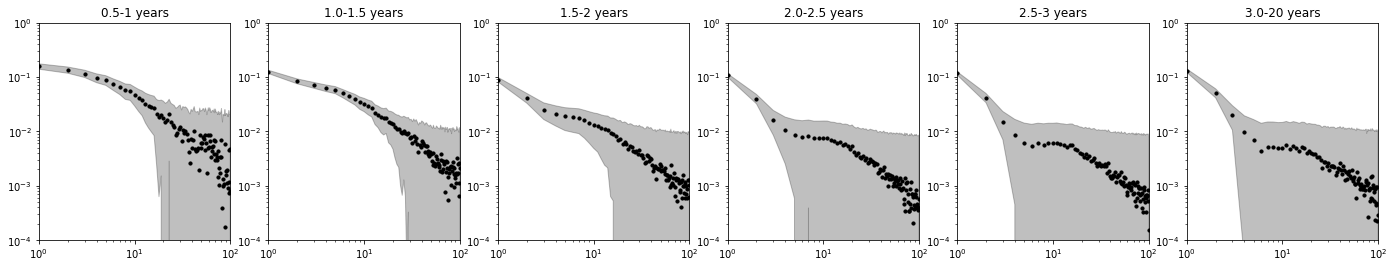

shuffled_within_sentence


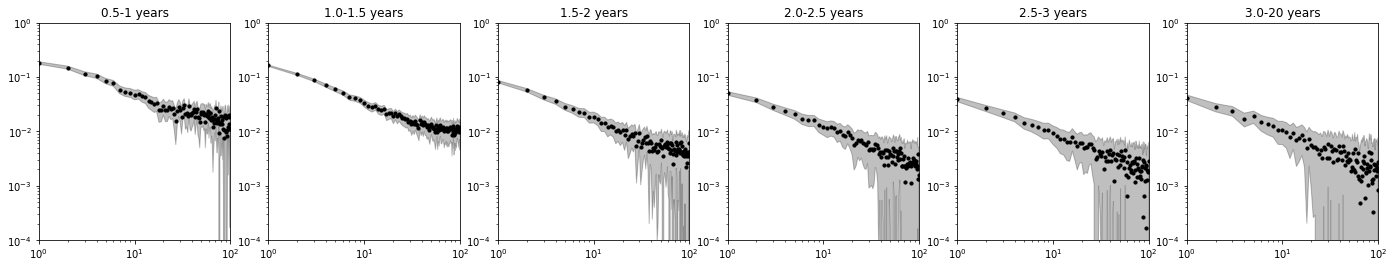

no_repeats


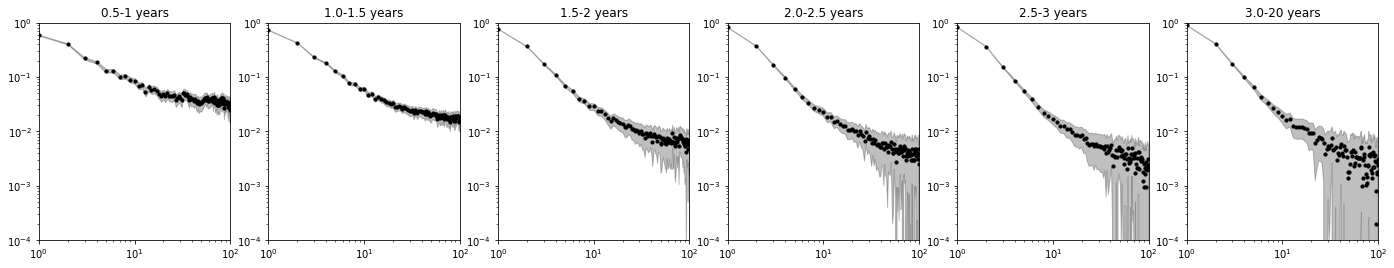

In [26]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_sentence', 'no_repeats']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-4,1])
        ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()